In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train.csv', 'sample_submission.csv', 'test.csv']


In [2]:
#import libraries
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch import optim
from torchvision import transforms

In [3]:
# Prepare Dataset
# load data
train = pd.read_csv(r"../input/train.csv",dtype = np.float32)

# split data into features(pixels) and labels(numbers from 0 to 9)
targets_numpy = train.label.values
features_numpy = train.loc[:,train.columns != "label"].values/255 # normalization

# train test split. Size of train data is 80% and size of test data is 20%. 
features_train, features_test, targets_train, targets_test = train_test_split(features_numpy,
                                                                             targets_numpy,
                                                                             test_size = 0.2,
                                                                             random_state = 42) 

# create feature and targets tensor for train set. As you remember we need variable to accumulate gradients. Therefore first we create tensor, then we will create variable
featuresTrain = torch.from_numpy(features_train)
targetsTrain = torch.from_numpy(targets_train).type(torch.LongTensor) # data type is long

# create feature and targets tensor for test set.
featuresTest = torch.from_numpy(features_test)
targetsTest = torch.from_numpy(targets_test).type(torch.LongTensor) # data type is long

# batch_size, epoch and iteration
batch_size = 100
n_iters = 10000
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
test = torch.utils.data.TensorDataset(featuresTest,targetsTest)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)


dataiter = iter(train_loader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([100, 784])
torch.Size([100])


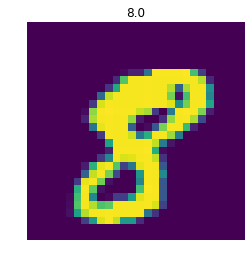

In [4]:
# visualize one of the images in data set
plt.imshow(features_numpy[10].reshape(28,28))
plt.axis("off")
plt.title(str(targets_numpy[10]))
plt.savefig('graph.png')
plt.show()


In [5]:
#import libraries and create model architecture
from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

In [6]:
model = Classifier()

images, labels = next(iter(test_loader))
# Get the class probabilities
ps = torch.exp(model(images))
# Make sure the shape is appropriate, we should get 10 class probabilities for 64 examples
print(ps.shape)

torch.Size([100, 10])


In [7]:
top_p, top_class = ps.topk(1, dim=1)
# Look at the most likely classes for the first 10 examples
print(top_class[:10,:])

tensor([[4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4]])


In [8]:
#equate topclass and labels
equals = top_class == labels.view(*top_class.shape)

In [9]:
accuracy = torch.mean(equals.type(torch.FloatTensor))
print(f'Accuracy: {accuracy.item()*100}%')

Accuracy: 7.999999821186066%


In [10]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in train_loader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            for images, labels in test_loader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(test_loader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(test_loader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))

Epoch: 1/30..  Training Loss: 0.358..  Test Loss: 0.167..  Test Accuracy: 0.950
Epoch: 2/30..  Training Loss: 0.126..  Test Loss: 0.118..  Test Accuracy: 0.964
Epoch: 3/30..  Training Loss: 0.086..  Test Loss: 0.161..  Test Accuracy: 0.955
Epoch: 4/30..  Training Loss: 0.067..  Test Loss: 0.128..  Test Accuracy: 0.965
Epoch: 5/30..  Training Loss: 0.060..  Test Loss: 0.167..  Test Accuracy: 0.957
Epoch: 6/30..  Training Loss: 0.046..  Test Loss: 0.145..  Test Accuracy: 0.965
Epoch: 7/30..  Training Loss: 0.041..  Test Loss: 0.133..  Test Accuracy: 0.968
Epoch: 8/30..  Training Loss: 0.035..  Test Loss: 0.123..  Test Accuracy: 0.972
Epoch: 9/30..  Training Loss: 0.034..  Test Loss: 0.130..  Test Accuracy: 0.969
Epoch: 10/30..  Training Loss: 0.028..  Test Loss: 0.140..  Test Accuracy: 0.969
Epoch: 11/30..  Training Loss: 0.027..  Test Loss: 0.134..  Test Accuracy: 0.972
Epoch: 12/30..  Training Loss: 0.027..  Test Loss: 0.154..  Test Accuracy: 0.967
Epoch: 13/30..  Training Loss: 0.022.

In [11]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

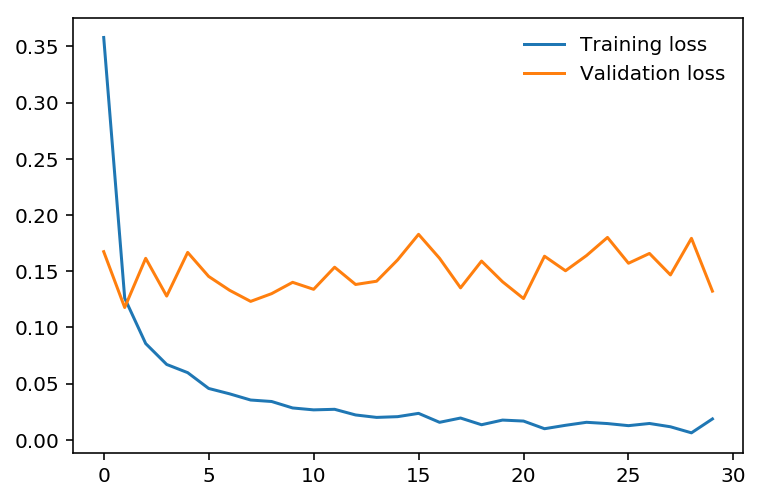

In [12]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

Here we can clearly see that our model is overfitting. So, let's add dropout to our model to lower validation loss.

In [13]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)

        # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))

        # output so no dropout here
        x = F.log_softmax(self.fc4(x), dim=1)

        return x

In [14]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in train_loader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval()
            for images, labels in test_loader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        model.train()
        
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(test_loader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(test_loader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))

Epoch: 1/30..  Training Loss: 0.579..  Test Loss: 0.229..  Test Accuracy: 0.929
Epoch: 2/30..  Training Loss: 0.213..  Test Loss: 0.165..  Test Accuracy: 0.949
Epoch: 3/30..  Training Loss: 0.156..  Test Loss: 0.130..  Test Accuracy: 0.960
Epoch: 4/30..  Training Loss: 0.119..  Test Loss: 0.107..  Test Accuracy: 0.967
Epoch: 5/30..  Training Loss: 0.097..  Test Loss: 0.105..  Test Accuracy: 0.969
Epoch: 6/30..  Training Loss: 0.085..  Test Loss: 0.104..  Test Accuracy: 0.970
Epoch: 7/30..  Training Loss: 0.070..  Test Loss: 0.098..  Test Accuracy: 0.971
Epoch: 8/30..  Training Loss: 0.067..  Test Loss: 0.095..  Test Accuracy: 0.973
Epoch: 9/30..  Training Loss: 0.056..  Test Loss: 0.087..  Test Accuracy: 0.974
Epoch: 10/30..  Training Loss: 0.049..  Test Loss: 0.094..  Test Accuracy: 0.973
Epoch: 11/30..  Training Loss: 0.048..  Test Loss: 0.091..  Test Accuracy: 0.975
Epoch: 12/30..  Training Loss: 0.041..  Test Loss: 0.092..  Test Accuracy: 0.975
Epoch: 13/30..  Training Loss: 0.040.

In [15]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

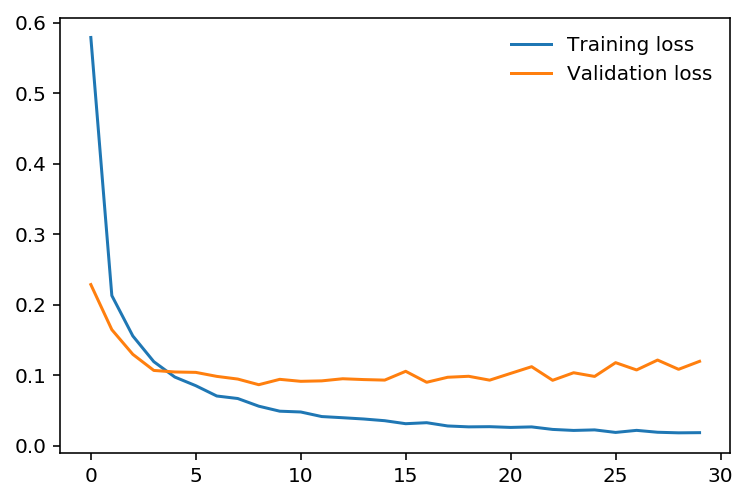

In [16]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

In [17]:
def plot(img,ps):
    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ps = ps.data.numpy().squeeze()
    
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    
    plt.tight_layout()

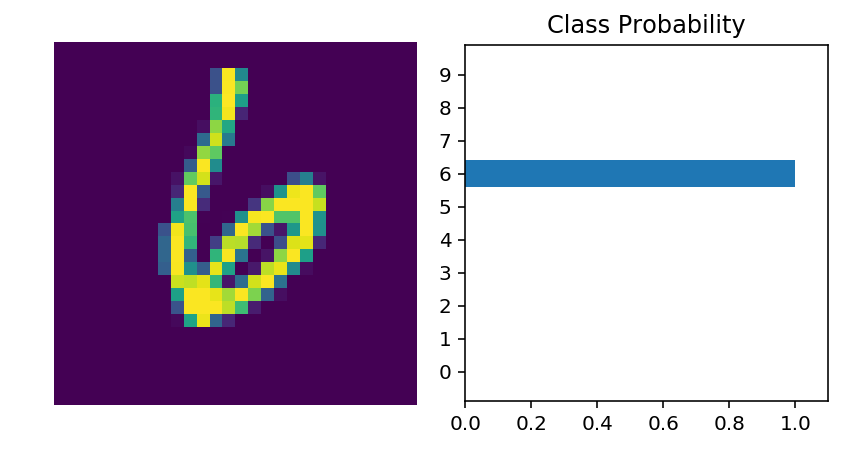

In [18]:
images, labels = next(iter(train_loader))

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model.forward(img)

# Output of the network are logits, need to take softmax for probabilities
ps = torch.exp(logps)
plot(img,ps)

In [19]:
#predictions of first 10 images
ps = torch.exp(model(images))
top_p, top_class = ps.topk(1,dim=1)
print(top_class[:10,:])

tensor([[6],
        [5],
        [3],
        [4],
        [7],
        [8],
        [6],
        [7],
        [0],
        [9]])


In [20]:
#equate topclass and labels
equals = top_class == labels.view(*top_class.shape)

In [21]:
accuracy = torch.mean(equals.type(torch.FloatTensor))
print(f'Accuracy: {accuracy.item()*100}%')

Accuracy: 100.0%
